In [1]:
import modelling_lib_rodrixx as mod
import preprocessing_lib_rodrixx as prep

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import os

from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

import mlflow

In [2]:
dataframes_path = os.path.join(os.getcwd(), 'dataframes')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [3]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1980_to_2021.pkl'))

- Drop players with more than one team
- Index with tuple for Rk & Player
- Drop the following columns:
     - Unuseful information: Rk, GT, MaxVotes, Tm, Pos
     - Correlation with another feature: FG_tot, 3PA_tot, 2PA_tot, FGA_rank_tot
     - With target information: Votes
- LabelEncode for Player, Pos and Team
- Separate types of columns

In [4]:
cols_to_drop = ['Rk', 'GT', 'Votes', 'MaxVotes', 'FG_tot', '3PA_tot', '2PA_tot', 'FGA_rank_tot', 'Tm', 'Pos']
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']
cols_to_ohe = ['Pos', 'Tm']

In [5]:
pipe = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('OutlierFilter', prep.OutlierFilter(q = .0005, col_to_filter = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [6]:
df = pipe.fit_transform(df)

In [7]:
df.head()

,,Age,G,GS,MP_pg,FG_pg,FGA_pg,FG%,3P_pg,3PA_pg,3P%,...,WS_rank,WS/48_rank,OBPM_rank,DBPM_rank,BPM_rank,VORP_rank,%W,%W_rank,%G,Share
Rk,Season,,,,,,,,,,,,,,,,,,,,,
1,1980,32,82,-10,38.3,10.2,16.9,0.604,0.0,0.0,0.000,...,1,1,5,7,2,1,0.732,2,1.000,0.665
2,1980,25,67,-10,18.2,2.3,4.7,0.481,0.0,0.0,0.000,...,71,83,50,32,54,41,0.293,44,0.817,0.000
3,1980,25,75,-10,28.9,6.2,11.7,0.531,0.0,0.0,0.000,...,27,21,23,11,12,12,0.671,6,0.915,0.000
4,1980,31,80,80,35.8,4.8,9.9,0.482,0.1,0.2,0.222,...,14,25,26,33,31,20,0.744,1,0.976,0.009
5,1980,31,26,-10,21.5,1.0,2.3,0.450,0.0,0.0,0.000,...,85,109,63,21,56,42,0.366,38,0.317,0.000


In [8]:
len(df[df['Season'] > 2015]) / len(df)

0.17507805847289243

In [9]:
val_df = df[df['Season'] > 2015]
dev_df = df[df['Season'] <= 2015]

In [10]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'smote', sampling_strategy = .35)

In [11]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [12]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [13]:
mlflow.set_experiment('NBA MVP prediction Elastic Net')

<Experiment: artifact_location='file:///C:/Users/marcr/OneDrive/Documents/Data%20Science/NBA%20Project/mlruns/2', experiment_id='2', lifecycle_stage='active', name='NBA MVP prediction Elastic Net', tags={}>

In [14]:
# param_grid = {
#     'max_depth': [6, 8, 10], 
#     'colsample_bytree': [.5], 
#     'learning_rate': [.1],
#     'subsample': [1, .8, .6],
#     'n_estimators': [1000]
#     }

In [15]:
# model.predict(StandardScaler().fit_transform(X_val))

In [16]:
# for key, value in datasets.items():
#     datasets[key] = pd.DataFrame(StandardScaler().fit_transform(value), columns = value.columns, index = value.index)

In [17]:
with mlflow.start_run():
    model = ElasticNet(alpha = .7, l1_ratio = .2)

    cv_scores = cross_validate(model, X_train, y_train, scoring = ('neg_root_mean_squared_error', 'r2'), cv = 10)

    model.fit(X_train, y_train)

    predicted_targets = mod.predict_model(model, datasets)

    params = model.get_params()

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_params_mlflow_enet(params)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_important_features_mlflow(mod.display_linear_coef(model))

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe['DropPlayers'].players_list_))

2022/07/01 19:04:46 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\marcr\AppData\Local\Temp\tmptxnw_7a4\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.


In [18]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.091905,0.081770,0.061154
R2,0.499006,0.253619,-0.167893


In [19]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe['DropPlayers'].players_list_)

In [20]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Player,Share,PredShare
Rk,Season,,,
105,2016,Stephen Curry,1.000,0.411103
263,2016,Kawhi Leonard,0.484,0.168058
222,2016,LeBron James,0.482,0.276158
452,2016,Russell Westbrook,0.371,0.311823
126,2016,Kevin Durant,0.112,0.337901
348,2016,Chris Paul,0.082,0.200348
167,2016,Draymond Green,0.038,0.165874
266,2016,Damian Lillard,0.020,0.194378
178,2016,James Harden,0.007,0.365498


,,Player,Share,PredShare
Rk,Season,,,
458,2017,Russell Westbrook,0.879,0.549661
173,2017,James Harden,0.746,0.487054
261,2017,Kawhi Leonard,0.495,0.252446
221,2017,LeBron James,0.330,0.343418
425,2017,Isaiah Thomas,0.080,0.297716
98,2017,Stephen Curry,0.051,0.279781
16,2017,Giannis Antetokounmpo,0.007,0.286041
453,2017,John Wall,0.007,0.241248
100,2017,Anthony Davis,0.002,0.348561


,,Player,Share,PredShare
Rk,Season,,,
195,2018,James Harden,0.955,0.396032
249,2018,LeBron James,0.731,0.431400
122,2018,Anthony Davis,0.441,0.360938
298,2018,Damian Lillard,0.205,0.249546
508,2018,Russell Westbrook,0.075,0.343700
16,2018,Giannis Antetokounmpo,0.074,0.320549
143,2018,Kevin Durant,0.065,0.292845
130,2018,DeMar DeRozan,0.032,0.182888
7,2018,LaMarcus Aldridge,0.006,0.154953


,,Player,Share,PredShare
Rk,Season,,,
18,2019,Giannis Antetokounmpo,0.932,0.435220
207,2019,James Harden,0.768,0.532559
184,2019,Paul George,0.352,0.308816
270,2019,Nikola Jokić,0.210,0.282926
124,2019,Stephen Curry,0.173,0.267113
305,2019,Damian Lillard,0.068,0.280174
155,2019,Joel Embiid,0.049,0.328941
150,2019,Kevin Durant,0.025,0.332897
301,2019,Kawhi Leonard,0.013,0.209381


,,Player,Share,PredShare
Rk,Season,,,
13,2020,Giannis Antetokounmpo,0.952,0.418259
251,2020,LeBron James,0.746,0.316462
199,2020,James Harden,0.363,0.433300
134,2020,Luka Dončić,0.198,0.337239
294,2020,Kawhi Leonard,0.166,0.226017
123,2020,Anthony Davis,0.081,0.253135
396,2020,Chris Paul,0.026,0.162104
297,2020,Damian Lillard,0.023,0.310591
262,2020,Nikola Jokić,0.018,0.239484


,,Player,Share,PredShare
Rk,Season,,,
263,2021,Nikola Jokić,0.961,0.377814
146,2021,Joel Embiid,0.580,0.239118
116,2021,Stephen Curry,0.449,0.331517
12,2021,Giannis Antetokounmpo,0.345,0.348681
396,2021,Chris Paul,0.138,0.170209
130,2021,Luka Dončić,0.042,0.327327
297,2021,Damian Lillard,0.038,0.294352
421,2021,Julius Randle,0.020,0.248297
439,2021,Derrick Rose,0.010,0.043382


No contenders results:


,,Player,Share,PredShare
Rk,Season,,,
1,2016,Quincy Acy,0.0,0.003024
5,2016,Alexis Ajinça,0.0,0.010003
6,2016,Cole Aldrich,0.0,0.023530
7,2016,LaMarcus Aldridge,0.0,0.097773
8,2016,Cliff Alexander,0.0,0.014413
...,...,...,...,...
536,2021,Delon Wright,0.0,0.053185
537,2021,Thaddeus Young,0.0,0.084344
538,2021,Trae Young,0.0,0.228016


In [21]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Player,Share,PredShare
Rk,Season,,,
19,2016,Giannis Antetokounmpo,0.0,0.103744
21,2016,Carmelo Anthony,0.0,0.138445
72,2016,Jimmy Butler,0.0,0.104858
97,2016,DeMarcus Cousins,0.0,0.235247
107,2016,Anthony Davis,0.0,0.169578
...,...,...,...,...
491,2021,Karl-Anthony Towns,0.0,0.156771
496,2021,Jonas Valančiūnas,0.0,0.138322
504,2021,Nikola Vučević,0.0,0.273571


<AxesSubplot:title={'center':'Most important features'}, xlabel='Feature', ylabel='Linear coefficient'>

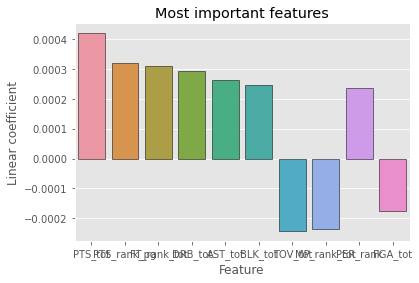

In [22]:
mod.display_linear_coef(model)

In [23]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe['DropPlayers'].players_list_)

(<Figure size 2880x2880 with 6 Axes>, <Figure size 2880x2880 with 6 Axes>)

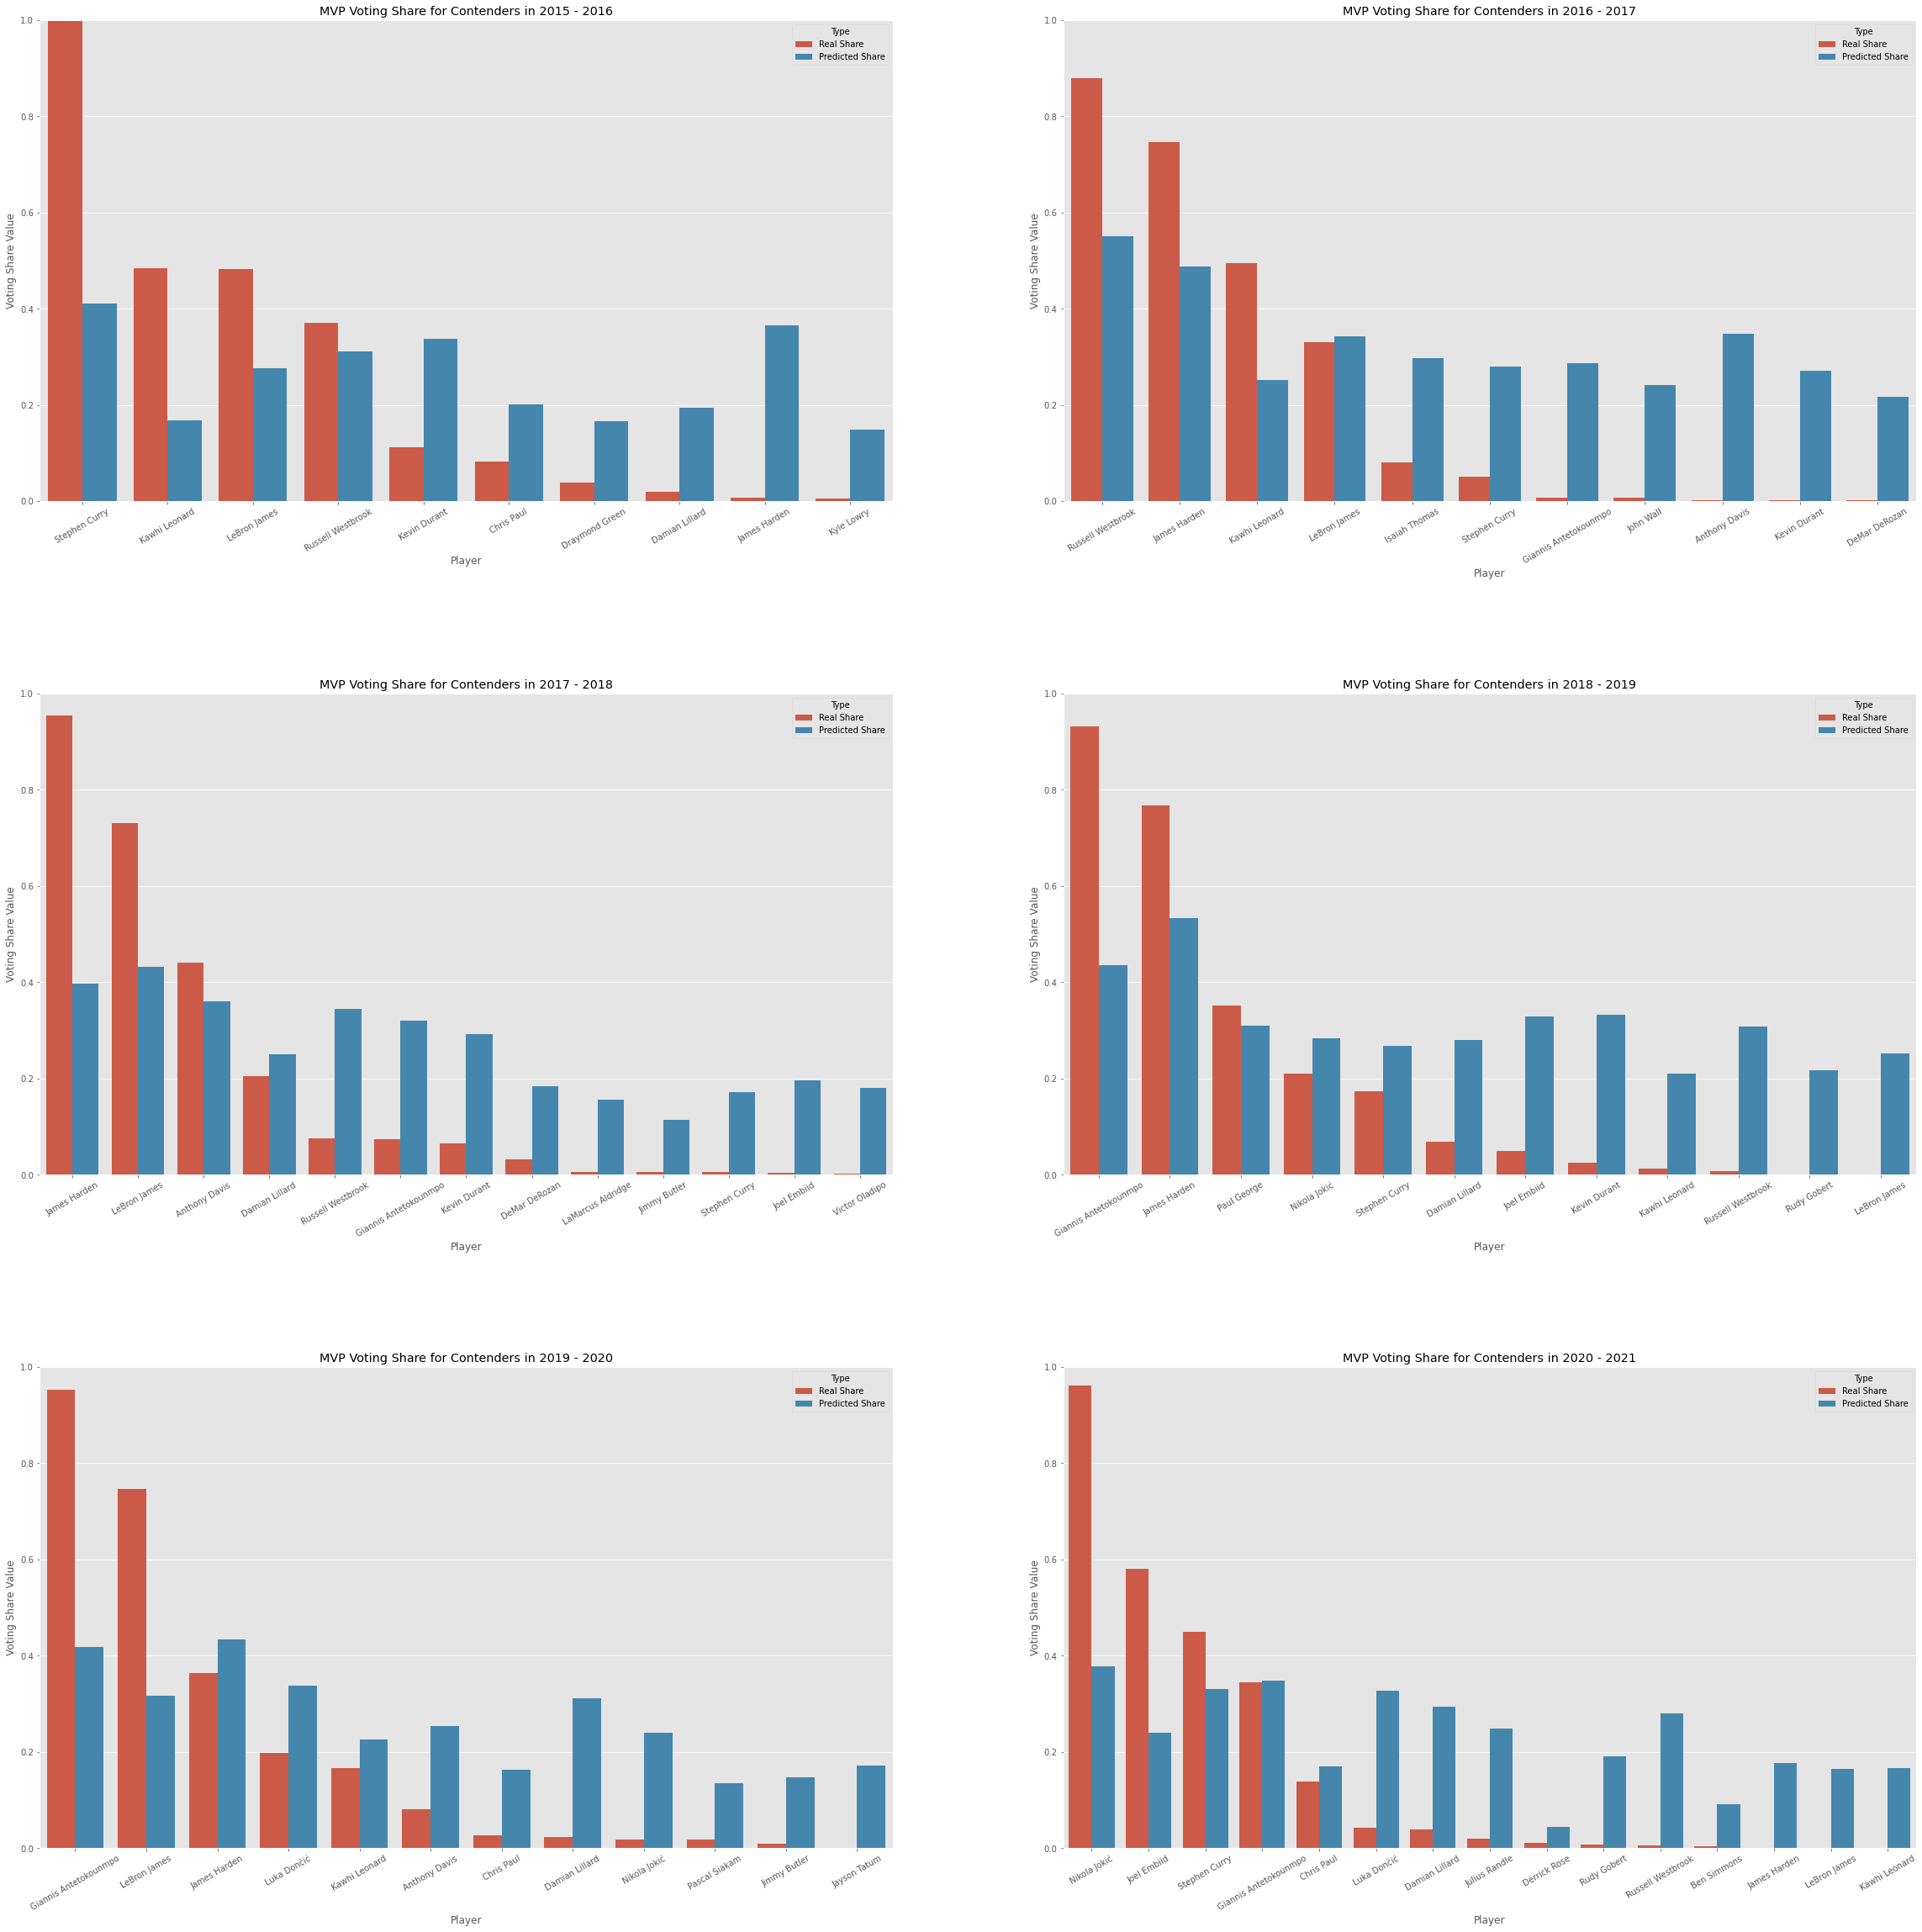

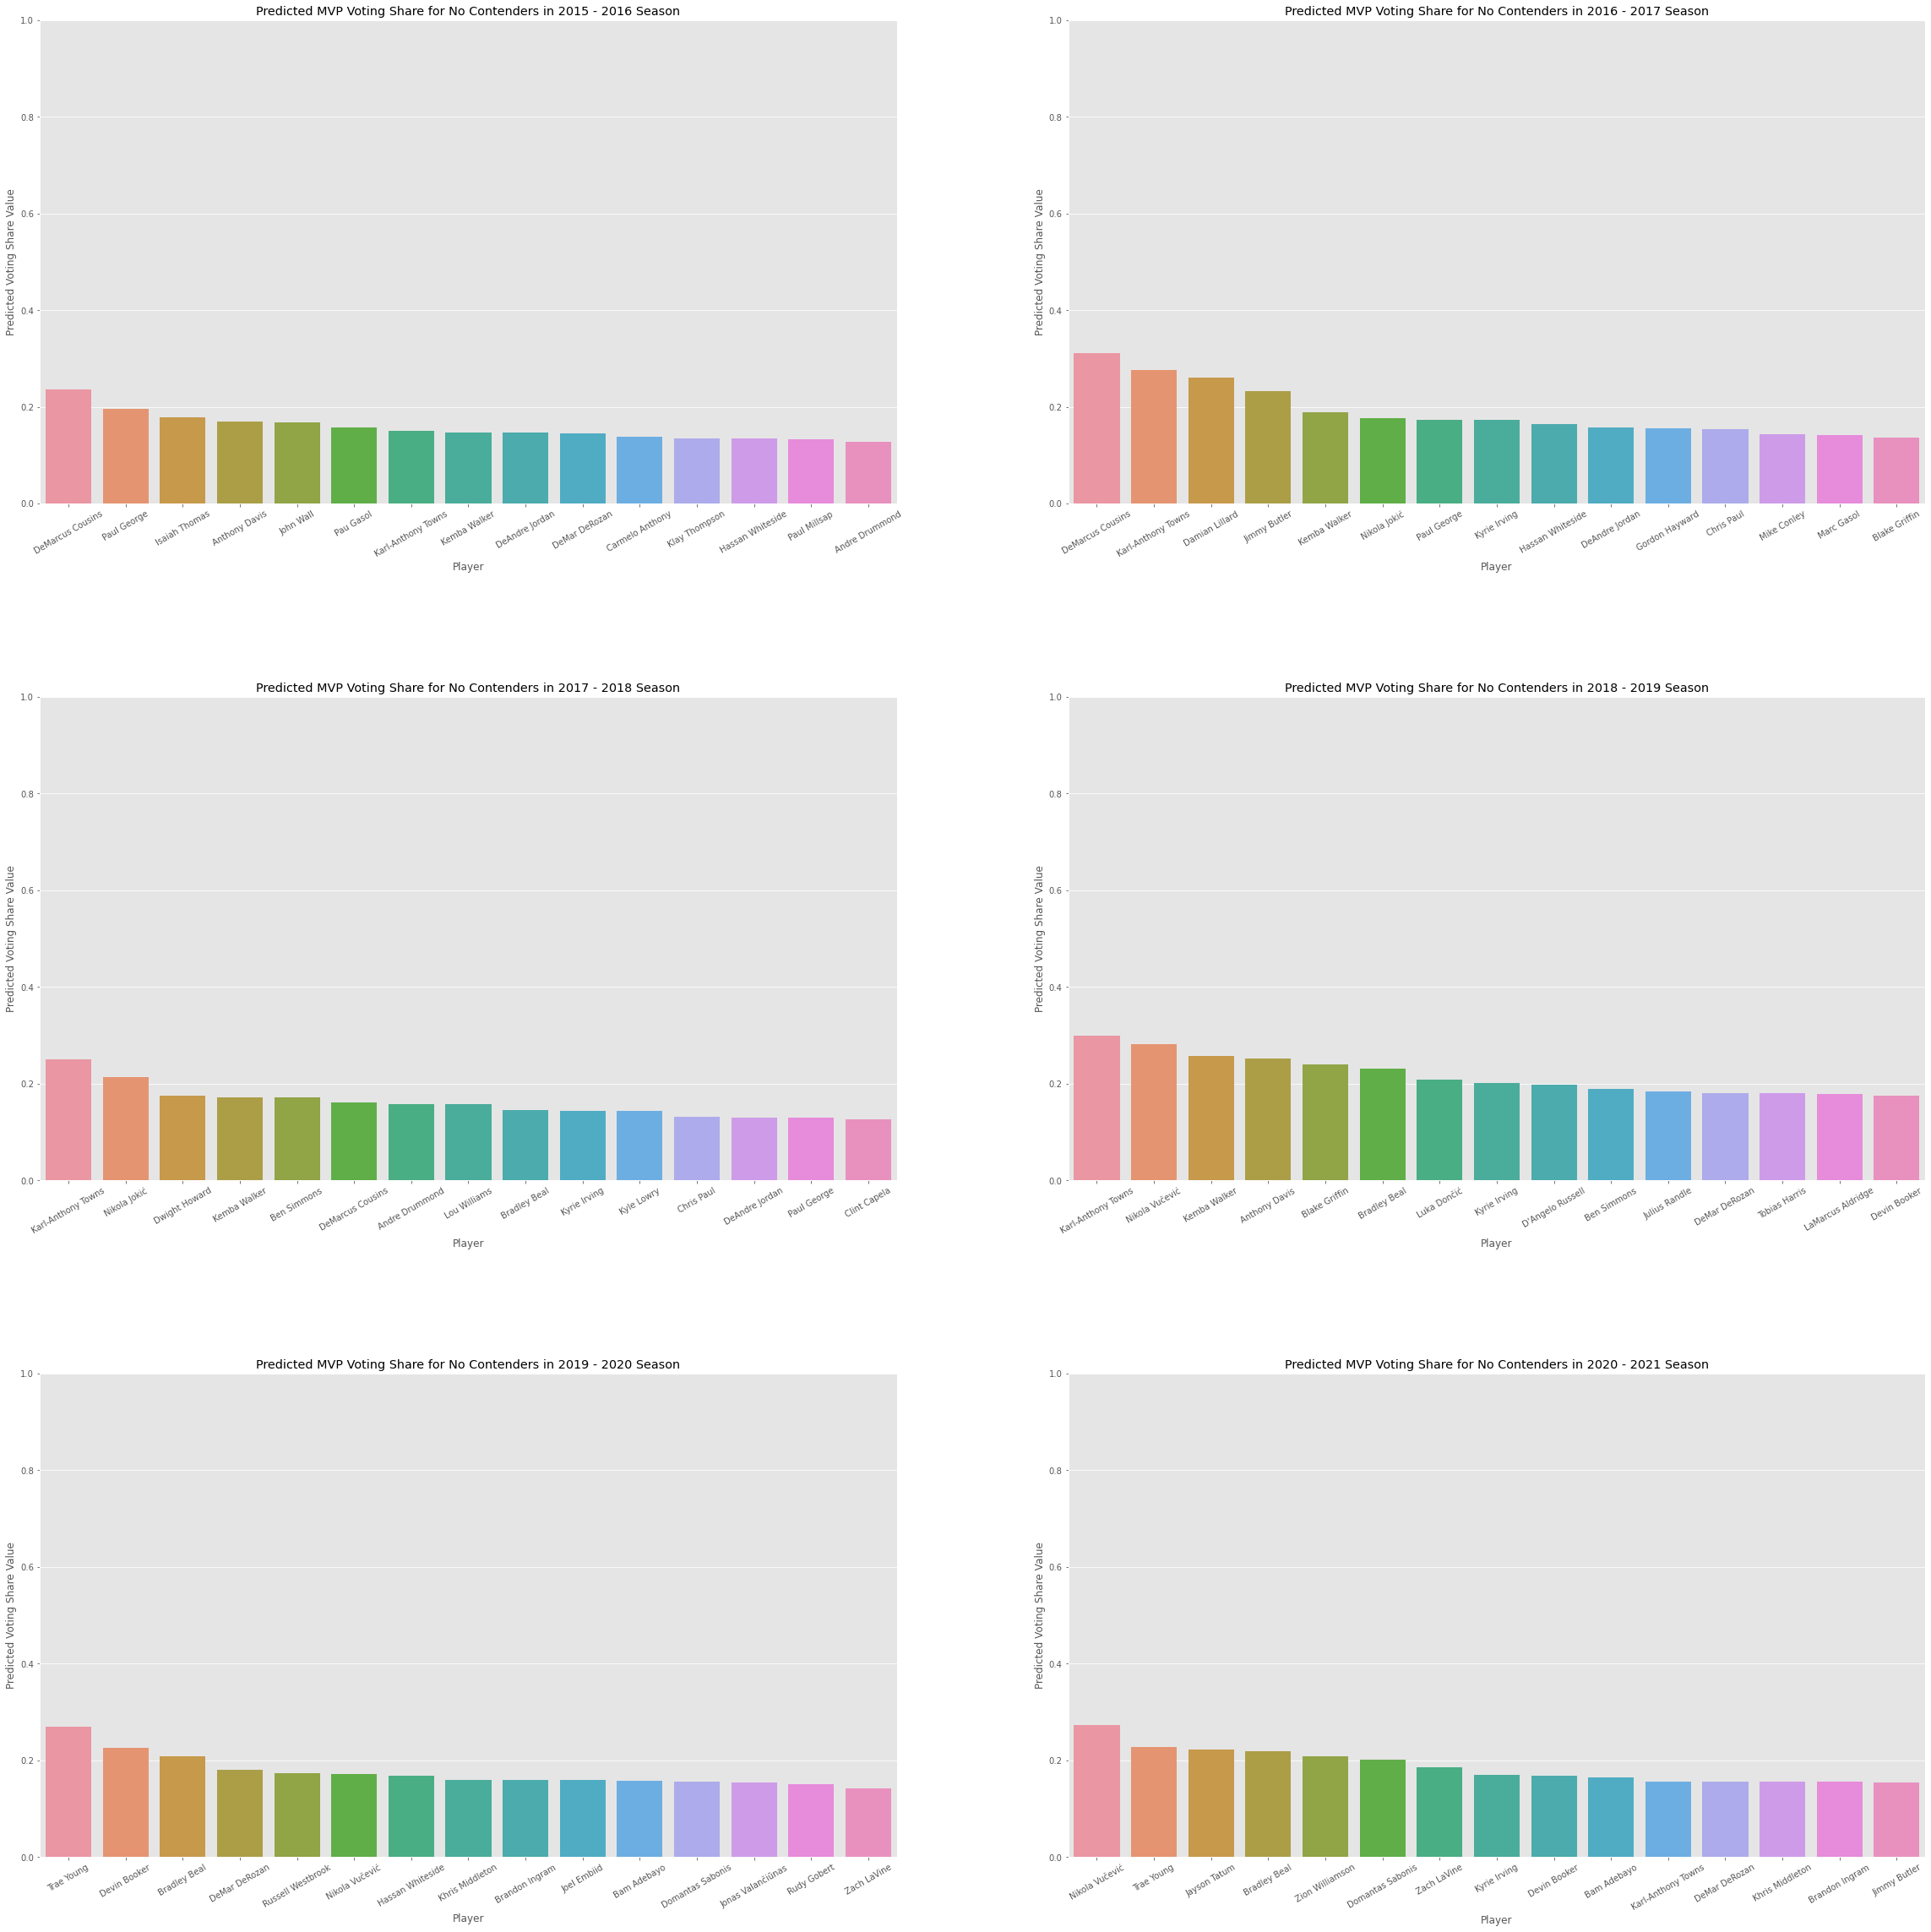

In [24]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe['DropPlayers'].players_list_)

In [25]:
# top_features = pd.DataFrame(best_model.feature_importances_, index = X_train.columns, columns = ['Importance']).sort_values('Importance', ascending = False)

In [26]:
# top_features[top_features['Importance'] > 0.005]